Final workflow k-means - VALIDATED:
- Clusters assigned to each sequence for 3 and 4 clusters
- Majority-vote mapping of clusters → morphotype
- Predicted morphotypes for each sequence based on cluster
- Classification reports showing precision, recall, f1-score
- Excel file with all info saved

In [ ]:
%pip install torch torchvision torchaudio
%pip install fair-esm
%pip install umap-learn seaborn pandas openpyxl


Finding optimal number of clusters...
Silhouette score for k=2: 0.1114
Silhouette score for k=3: 0.1356
Silhouette score for k=4: 0.1219
Silhouette score for k=5: 0.0938
Silhouette score for k=6: 0.0084
Silhouette score for k=7: 0.1021
Silhouette score for k=8: 0.1620
Silhouette score for k=9: 0.1284

Best number of clusters: 8 (score=0.1620)

Cluster to Morphotype Mapping:
{1: 'Siphoviridae', 6: 'Podoviridae', 4: 'Podoviridae', 2: 'Podoviridae', 7: 'Siphoviridae', 5: 'Myoviridae', 0: 'Podoviridae', 3: 'Podoviridae'}

Classification Report:
              precision    recall  f1-score   support

  Myoviridae       1.00      0.07      0.12        15
 Podoviridae       1.00      0.36      0.53        25
Siphoviridae       0.38      1.00      0.55        18

    accuracy                           0.48        58
   macro avg       0.79      0.48      0.40        58
weighted avg       0.81      0.48      0.43        58



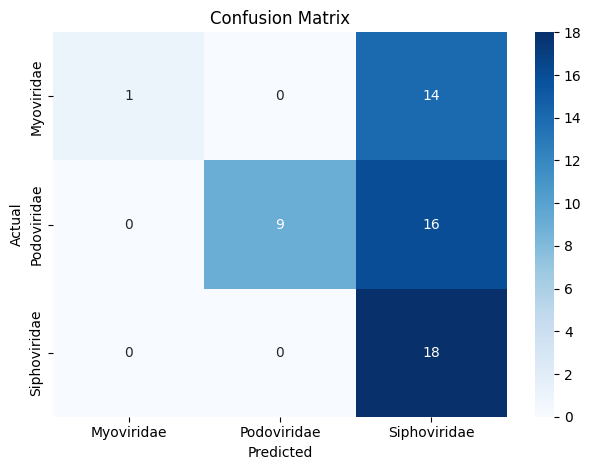


Saved results to 'phage_clustered_with_morphotypes.xlsx'


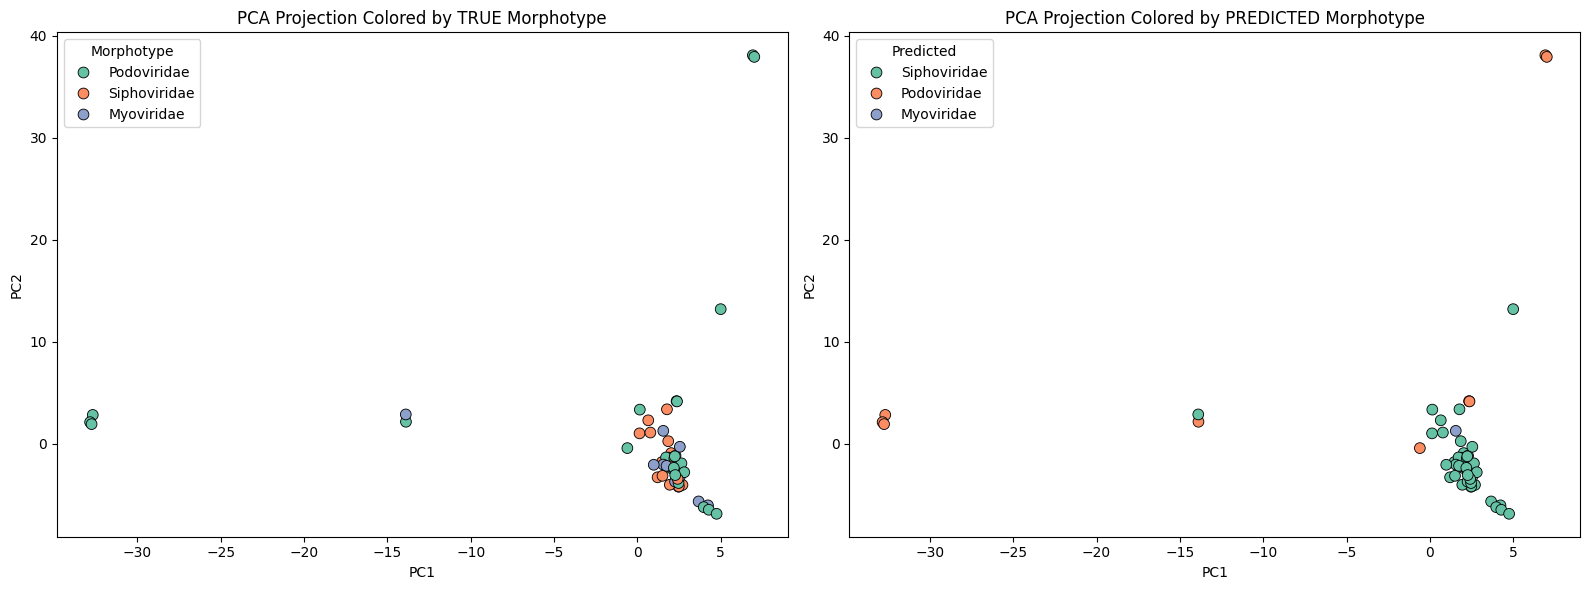

C:\Users\catia\AppData\Local\Temp\ipykernel_18984\4132025442.py:107: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



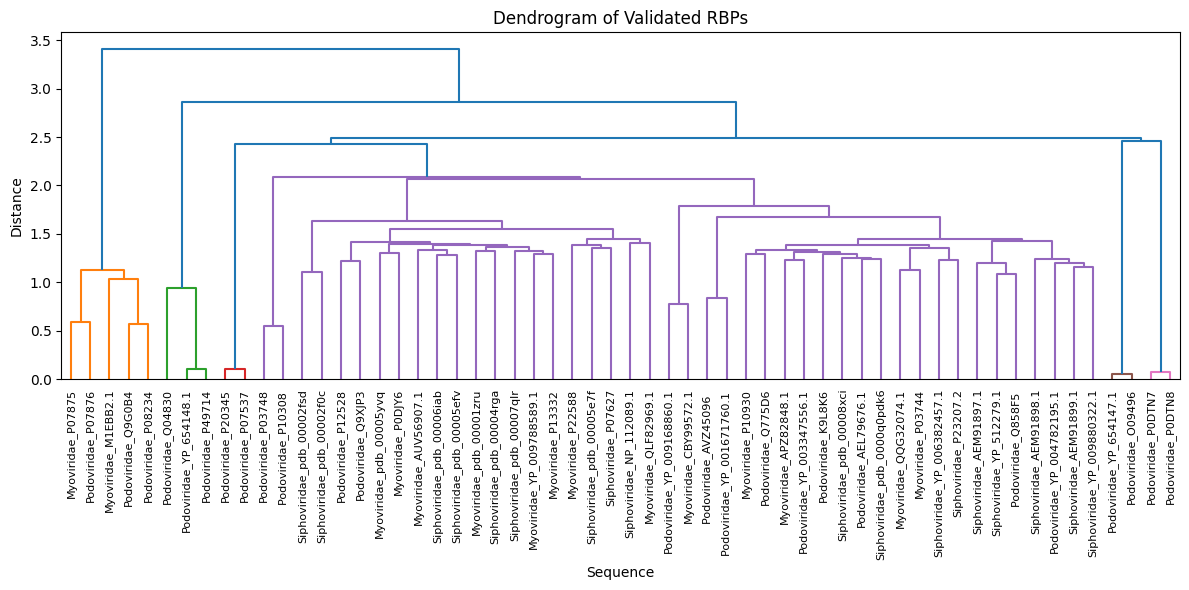

In [33]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score, classification_report, pairwise_distances
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns

# === Load Data ===
df = pd.read_excel("validated_processed.xlsx")
sequences = df["CleanSeq"].astype(str).tolist()

# === Vectorize Sequences with CountVectorizer (3–4-mers) ===
vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 4))
X0 = vectorizer.fit_transform(sequences)

# === Find Optimal K Using Silhouette Score ===
best_k = None
best_score = -1
score_dict = {}

print("\nFinding optimal number of clusters...")
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    score_dict[k] = score
    print(f"Silhouette score for k={k}: {score:.4f}")
    if score > best_score:
        best_score = score
        best_k = k

print(f"\nBest number of clusters: {best_k} (score={best_score:.4f})")

# === Final KMeans with Best K ===
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df["BestKMeans_Cluster"] = kmeans.fit_predict(X)

# === Majority Vote Mapping from Cluster to Morphotype ===
def assign_morphotypes_by_majority(df, cluster_col, morph_col):
    mapping = {}
    for cluster in df[cluster_col].unique():
        subset = df[df[cluster_col] == cluster]
        most_common = subset[morph_col].mode()
        if not most_common.empty:
            mapping[cluster] = most_common.iloc[0]
        else:
            mapping[cluster] = "Unknown"
    return mapping

def apply_cluster_to_morphotype_mapping(df, cluster_col, mapping):
    return df[cluster_col].map(mapping).fillna("Unknown")

cluster_to_morph = assign_morphotypes_by_majority(df, "BestKMeans_Cluster", "Morphotype")
df["Predicted_morphotype"] = apply_cluster_to_morphotype_mapping(df, "BestKMeans_Cluster", cluster_to_morph)

print(f"\nCluster to Morphotype Mapping:\n{cluster_to_morph}")

# === Evaluate ===
valid_rows = df["Predicted_morphotype"].notna()
print("\nClassification Report:")
print(classification_report(
    df.loc[valid_rows, "Morphotype"],
    df.loc[valid_rows, "Predicted_morphotype"],
    zero_division=0
))

# === Confusion Matrix ===
conf_mat = pd.crosstab(df["Morphotype"], df["Predicted_morphotype"], rownames=["Actual"], colnames=["Predicted"])
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# === Save Results ===
df.to_excel("phage_clustered_with_morphotypes.xlsx", index=False)
print("\nSaved results to 'phage_clustered_with_morphotypes.xlsx'")

# === PCA Visualization ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X0.toarray())

# Add PCA coordinates
df["PC1"] = X_pca[:, 0]
df["PC2"] = X_pca[:, 1]

# Plot PCA Results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(data=df, x="PC1", y="PC2", hue="Morphotype", palette="Set2",
                s=60, edgecolor='k', ax=axes[0])
axes[0].set_title("PCA Projection Colored by TRUE Morphotype")
axes[0].legend(title="Morphotype", loc='best')

sns.scatterplot(data=df, x="PC1", y="PC2", hue="Predicted_morphotype", palette="Set2",
                s=60, edgecolor='k', ax=axes[1])
axes[1].set_title("PCA Projection Colored by PREDICTED Morphotype")
axes[1].legend(title="Predicted", loc='best')

plt.tight_layout()
plt.show()

# === Dendrogram Visualization ===
distance_matrix = pairwise_distances(X0.toarray(), metric='cosine')
Z = linkage(distance_matrix, method='ward')

plt.figure(figsize=(12, 6))
labels = df.apply(lambda row: f"{row['Morphotype']}_{row['RBP Accession']}", axis=1).values
dendrogram(Z, labels=labels, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrogram of Validated RBPs')
plt.xlabel('Sequence')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()


In [34]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, fcluster
import plotly.figure_factory as ff

# Compute the distance matrix
distance_matrix = pairwise_distances(X0.toarray(), metric='cosine')

# Linkage matrix
Z = linkage(distance_matrix, method='ward')

# Choose how many final clusters to keep
p = 50  # For example, 30 largest clusters

# Get cluster assignments
clusters = fcluster(Z, t=p, criterion='maxclust')

# Add cluster info to df
df['ClusterPlot'] = clusters

# Pick one representative RBP from each cluster
# (optional: pick based on other metrics, but here we just sample)
rep_indices = df.groupby('ClusterPlot').head(1).index

# Filter data
X_small = X0.toarray()[rep_indices]
labels_small = df.loc[rep_indices].apply(lambda row: f"{row['Morphotype']}_{row['RBP Accession']}", axis=1).tolist()

# Compute reduced distance matrix and linkage again
distance_matrix_small = pairwise_distances(X_small, metric='cosine')
Z_small = linkage(distance_matrix_small, method='ward')

# Plot using Plotly
fig = ff.create_dendrogram(distance_matrix_small, labels=labels_small, 
                           linkagefun=lambda x: linkage(x, method='ward'))
fig.update_layout(
    width=1600, height=800,
    title='Simplified Dendrogram of Representative RBPs - Validated',
    xaxis_title='Representative RBP',
    yaxis_title='Distance'
)
fig.show()

C:\Users\catia\AppData\Local\Temp\ipykernel_18984\3918923952.py:11: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

C:\Users\catia\AppData\Local\Temp\ipykernel_18984\3918923952.py:32: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [2]:
print(df["Morphotype"].value_counts())
print(df["Predicted_morphotype"].value_counts())


Morphotype
Podoviridae     25
Siphoviridae    18
Myoviridae      15
Name: count, dtype: int64
Predicted_morphotype
Podoviridae     36
Myoviridae      19
Siphoviridae     3
Name: count, dtype: int64


-----------------------------------------------------------------------------------

Final workflow k-means - VALIDATED AND NONVALIDATED:
- Clusters assigned to each sequence for 3 and 4 clusters
- Majority-vote mapping of clusters → morphotype
- Predicted morphotypes for each sequence based on cluster
- Classification reports showing precision, recall, f1-score
- Excel file with all info saved

Finding best k based on silhouette score...
k=2, silhouette score=0.1773
k=3, silhouette score=0.0427
k=4, silhouette score=0.0441
Best k = 2 with silhouette score = 0.1773


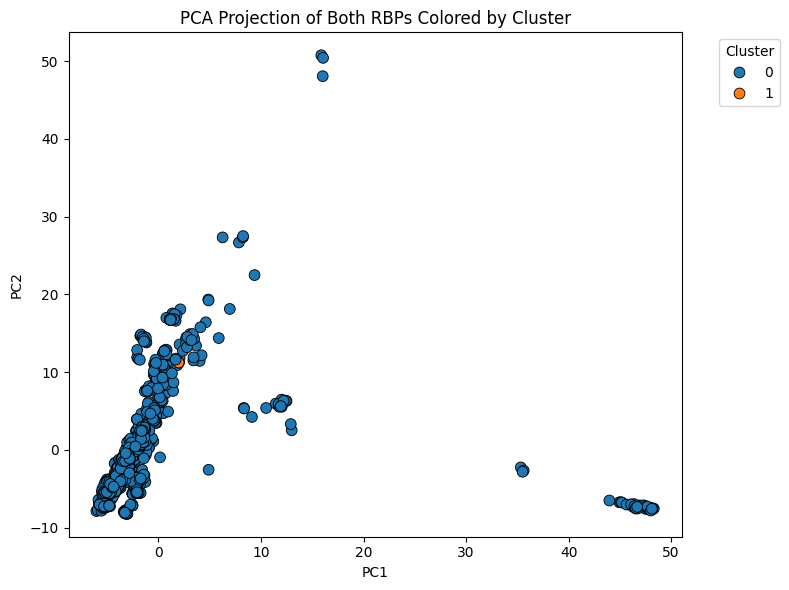

C:\Users\catia\AppData\Local\Temp\ipykernel_18984\2540408873.py:53: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



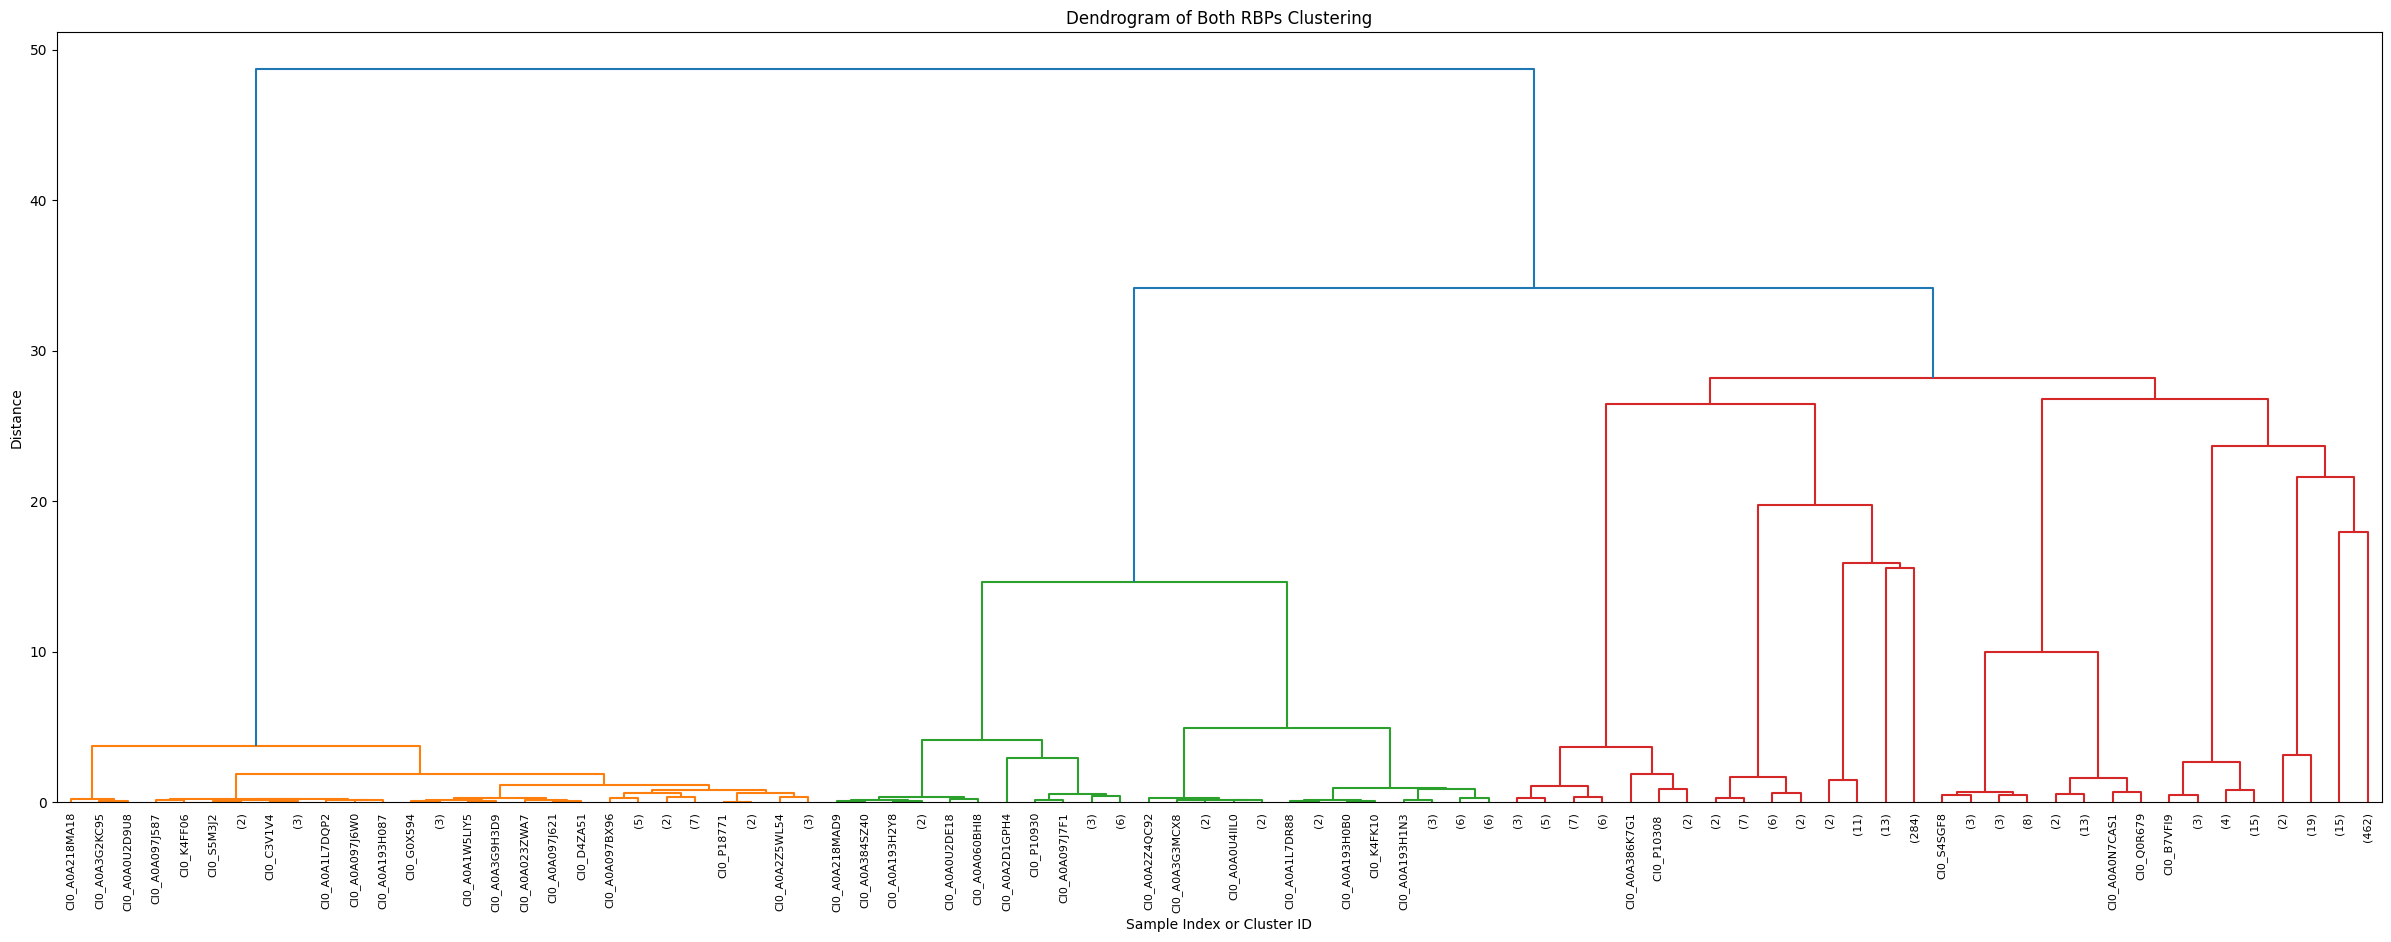


Saved results to 'rbp_clustered_results_unsupervised.xlsx'


In [35]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns

# === Load dataset ===
df = pd.read_excel("phage_processed1.xlsx")

# === Vectorization with CountVectorizer ===
sequences = df["CleanSeq"].astype(str).tolist()
vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 4))
X1 = vectorizer.fit_transform(sequences)

# === Find optimal k using silhouette score ===
print("Finding best k based on silhouette score...")
best_k = None
best_score = -1
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X1)
    score = silhouette_score(X1, labels)
    print(f"k={k}, silhouette score={score:.4f}")
    if score > best_score:
        best_score = score
        best_k = k
print(f"Best k = {best_k} with silhouette score = {best_score:.4f}")

# === Final clustering with best k ===
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
df['Cluster'] = kmeans.fit_predict(X1)

# === PCA Visualization ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X1.toarray())
df["PC1"] = X_pca[:, 0]
df["PC2"] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="PC1", y="PC2", hue="Cluster", palette="tab10", s=60, edgecolor='k')
plt.title("PCA Projection of Both RBPs Colored by Cluster")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# === Dendrogram Visualization ===
distance_matrix = pairwise_distances(X1.toarray(), metric='cosine')

Z = linkage(distance_matrix, method='ward')

plt.figure(figsize=(30, 10))
labels = df.apply(lambda row: f"Cl{row['Cluster']}_{row['RBP_Accession']}", axis=1).values
dendrogram(Z, labels=labels, truncate_mode='level', p=6, leaf_rotation=90)
plt.xticks(rotation=90, size=8)
plt.title('Dendrogram of Both RBPs Clustering')
plt.xlabel('Sample Index or Cluster ID')
plt.ylabel('Distance')
plt.show()

# === Save results ===
df.to_excel("rbp_clustered_results_unsupervised.xlsx", index=False)
print("\nSaved results to 'rbp_clustered_results_unsupervised.xlsx'")

In [36]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, fcluster
import plotly.figure_factory as ff

# Compute the distance matrix
distance_matrix = pairwise_distances(X1.toarray(), metric='cosine')

# Linkage matrix
Z = linkage(distance_matrix, method='ward')

# Choose how many final clusters to keep
p = 50  # For example, 30 largest clusters

# Get cluster assignments
clusters = fcluster(Z, t=p, criterion='maxclust')

# Add cluster info to df
df['ClusterPlot'] = clusters

# Pick one representative RBP from each cluster
# (optional: pick based on other metrics, but here we just sample)
rep_indices = df.groupby('ClusterPlot').head(1).index

# Filter data
X_small = X1.toarray()[rep_indices]
labels_small = df.loc[rep_indices].apply(lambda row: f"Cl{row['Cluster']}_{row['RBP_Accession']}", axis=1).tolist()

# Compute reduced distance matrix and linkage again
distance_matrix_small = pairwise_distances(X_small, metric='cosine')
Z_small = linkage(distance_matrix_small, method='ward')

# Plot using Plotly
fig = ff.create_dendrogram(distance_matrix_small, labels=labels_small, 
                           linkagefun=lambda x: linkage(x, method='ward'))
fig.update_layout(
    width=1600, height=800,
    title='Simplified Dendrogram of Representative RBPs - Both Datasets',
    xaxis_title='Representative RBP',
    yaxis_title='Distance'
)
fig.show()

C:\Users\catia\AppData\Local\Temp\ipykernel_18984\2323602713.py:11: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

C:\Users\catia\AppData\Local\Temp\ipykernel_18984\2323602713.py:32: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [37]:
best_score = -1
best_params = {}

for k in range(2, 10):
    for init_method in ['k-means++', 'random']:
        model = KMeans(n_clusters=k, init=init_method, random_state=42, n_init='auto')
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_params = {'n_clusters': k, 'init': init_method}

print(f"Best params: {best_params} with silhouette score: {best_score:.4f}")

Best params: {'n_clusters': 4, 'init': 'random'} with silhouette score: 0.1285


------------------------------------------------------------------------------------------------------------------

Final workflow k-means - NONVALIDATED:
- Clusters assigned to each sequence for 3 and 4 clusters
- Majority-vote mapping of clusters → morphotype
- Predicted morphotypes for each sequence based on cluster
- Classification reports showing precision, recall, f1-score
- Excel file with all info saved

Finding optimal number of clusters by silhouette score...
k=2, silhouette score=0.2001
k=3, silhouette score=-0.0552
k=4, silhouette score=-0.0433
k=5, silhouette score=-0.0320

Best k=2 with silhouette score=0.2001
Best number of clusters: 2 with silhouette score: 0.2001


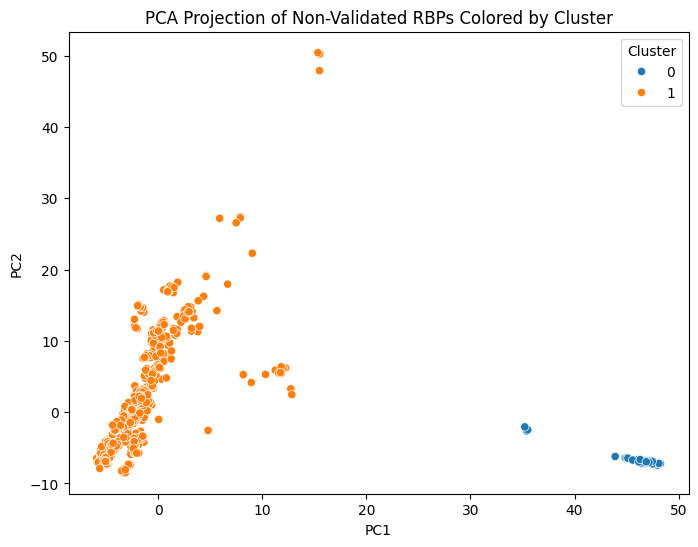

C:\Users\catia\AppData\Local\Temp\ipykernel_18064\799843467.py:57: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')


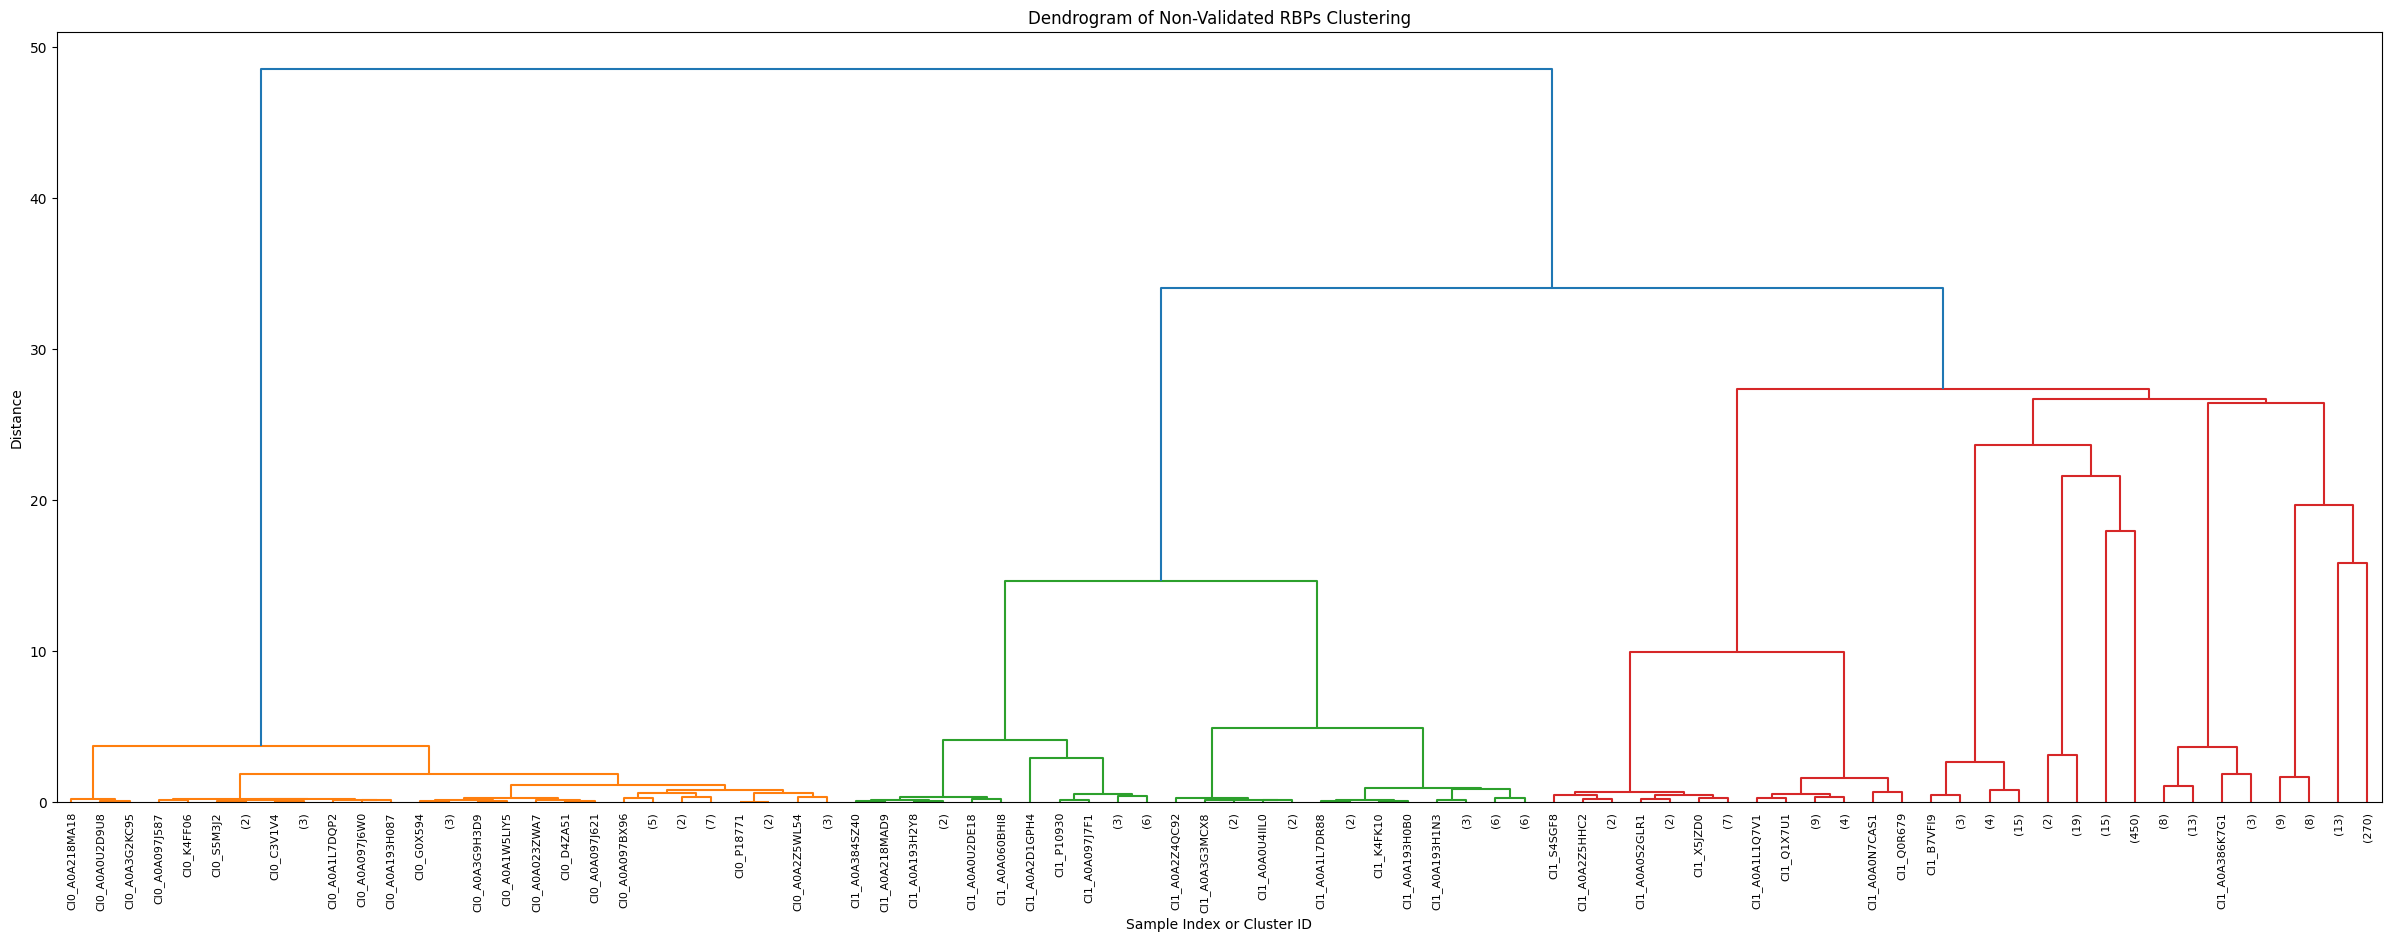

Saved clustering results to rbp_clustered_results_onlyNV_countvec.xlsx


In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage

# === Load data ===
df = pd.read_excel("phage_processed2.xlsx")
sequences = df["RBP sequence (aa)"].astype(str).tolist()

# === Vectorize sequences using CountVectorizer of 3-4-mers ===
vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 4))
X = vectorizer.fit_transform(sequences)

# === Best number of clusters by Silhouette score ===
print("Finding optimal number of clusters by silhouette score...")

best_k = None
best_score = -1
scores = []

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)
    print(f"k={k}, silhouette score={score:.4f}")
    if score > best_score:
        best_score = score
        best_k = k

print(f"\nBest k={best_k} with silhouette score={best_score:.4f}")

best_model = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
df['Cluster'] = best_model.fit_predict(X)

print(f"Best number of clusters: {best_k} with silhouette score: {best_score:.4f}")

# === PCA ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
df['PC1'] = X_pca[:, 0]
df['PC2'] = X_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette='tab10', legend='full')
plt.title('PCA Projection of Non-Validated RBPs Colored by Cluster')
plt.show()

# === Dendrogram Visualization ===
distance_matrix = pairwise_distances(X.toarray(), metric='cosine')

Z = linkage(distance_matrix, method='ward')

plt.figure(figsize=(30, 10))
labels = df.apply(lambda row: f"Cl{row['Cluster']}_{row['RBP accession nr']}", axis=1).values
dendrogram(Z, labels=labels, truncate_mode='level', p=6, leaf_rotation=90)
plt.xticks(rotation=90, size=8)
plt.title('Dendrogram of Non-Validated RBPs Clustering')
plt.xlabel('Sample Index or Cluster ID')
plt.ylabel('Distance')
plt.show()

# === Save results ===
df.to_excel("rbp_clustered_results_onlyNV_countvec.xlsx", index=False)
print("Saved clustering results to rbp_clustered_results_onlyNV_countvec.xlsx")


In [39]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, fcluster
import plotly.figure_factory as ff

# Compute the distance matrix
distance_matrix = pairwise_distances(X.toarray(), metric='cosine')

# Linkage matrix
Z = linkage(distance_matrix, method='ward')

# Choose how many final clusters to keep
p = 50  # For example, 30 largest clusters

# Get cluster assignments
clusters = fcluster(Z, t=p, criterion='maxclust')

# Add cluster info to df
df['ClusterPlot'] = clusters

# Pick one representative RBP from each cluster
# (optional: pick based on other metrics, but here we just sample)
rep_indices = df.groupby('ClusterPlot').head(1).index

# Filter data
X_small = X.toarray()[rep_indices]
labels_small = df.loc[rep_indices].apply(lambda row: f"Cl{row['Cluster']}_{row['RBP accession nr']}", axis=1).tolist()

# Compute reduced distance matrix and linkage again
distance_matrix_small = pairwise_distances(X_small, metric='cosine')
Z_small = linkage(distance_matrix_small, method='ward')

# Plot using Plotly
fig = ff.create_dendrogram(distance_matrix_small, labels=labels_small, 
                           linkagefun=lambda x: linkage(x, method='ward'))
fig.update_layout(
    width=1600, height=800,
    title='Simplified Dendrogram of Representative RBPs - Non-Validated',
    xaxis_title='Representative RBP',
    yaxis_title='Distance'
)
fig.show()


C:\Users\catia\AppData\Local\Temp\ipykernel_18984\2435402851.py:11: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

C:\Users\catia\AppData\Local\Temp\ipykernel_18984\2435402851.py:32: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [62]:
best_score = -1
best_params = {}

for k in range(2, 10):
    for init_method in ['k-means++', 'random']:
        model = KMeans(n_clusters=k, init=init_method, random_state=42, n_init='auto')
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_params = {'n_clusters': k, 'init': init_method}

print(f"Best params: {best_params} with silhouette score: {best_score:.4f}")


Best params: {'n_clusters': 9, 'init': 'random'} with silhouette score: 0.0810
